# 深度学习处理时间序列
---
* 处理时间序列数据的机器学习任务实例
* 理解循环神经网络
* 将循环神经网络应用于温度预测示例
* 循环神经网络的高级用法

## 10.1 不同类型的时间序列任务
* 分类
* 事件检测
* 异常检测

## 10.2 温度预测示例

### [C] 查看Jena天气数据集

In [7]:
import os

fname = os.path.join('jena_climate_2009_2016.csv')

with open(fname) as f:
    data = f.read()

lines  = data.split('\n')
header = lines[0].split(',')
lines  = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


### [C] 10.2 解析数据
---
#### 将数据转换为NumPy数组

In [8]:
import numpy as np

temperature = np.zeros((len(lines),                ))
raw_data    = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]

    # 将第一列保存在temperature数组中
    temperature[i] = values[1]
    # 将所有列保存在raw_data数组中
    raw_data[i]    = values[:]

### [C] 10.3 绘制温度时间序列

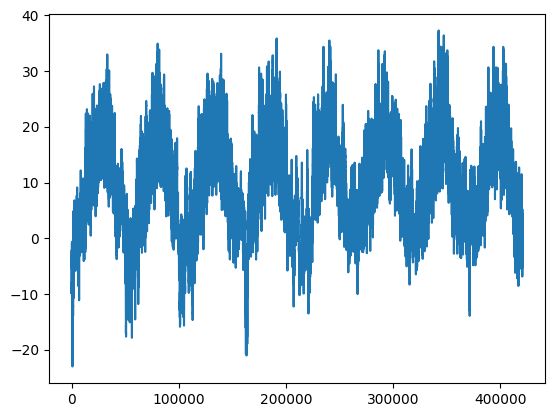

In [9]:
from matplotlib import pyplot as plt

plt.plot(range(len(temperature)), temperature)

### [C] 10.4 绘制前10天的温度时间序列

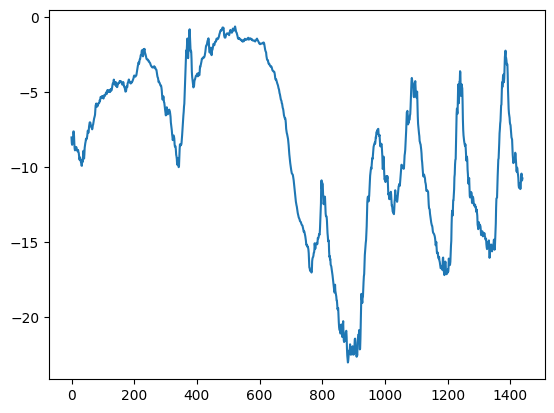

In [10]:
# 数据特征：每10分钟记录一次数据，每天有 24 X 6 = 144 个数据点
plt.plot(range(1440), temperature[:1440])

### * 在接下来的示例中，前50%的数据用于训练，随后25%用于验证，最后的25%用于测试
### * 重点：验证数据和测试数据应比训练数据更靠后。

### [C] 10.5 计算用于训练、验证和测试的样本数

In [11]:
num_train_samples = int(0.5  * len(raw_data))
num_val_samples   = int(0.25 * len(raw_data))
num_test_samples  = len(raw_data)- num_train_samples - num_val_samples

print('num_train_sample:', num_train_samples)
print('num_val_sample:'  , num_val_samples)
print('num_test_sample:' , num_test_samples)

num_train_sample: 210225
num_val_sample: 105112
num_test_sample: 105114


### 10.2.1 准备数据
---
**设定问题：每小时采样一次数据,给定前5天的数据,我们能否预测24小时之后的温度？**
**Given data covering the previous five days and sampled once per hour, can we predict the temperature in 24 hours?**

#### [C] 10.6 数据规范化

In [12]:
mean      = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean

std       = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [13]:
import numpy as np
from tensorflow import keras

# 生成一个从0到9的有序整数数组
int_sequence = np.arange(10)

dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data            = int_sequence[:-3], # 序列将从[0,1,2,3,4,5,6]中抽样
    targets         = int_sequence[3:],  # 对于以data[N]开头的序列，其目标时data[N + 3]
    sequence_length = 3,                 # 序列长度是3个时间步
    batch_size      = 2,                 # 序列批量大小为2
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


#### [C] 10.7 创建3个数据集，分别用于训练、验证和测试

In [14]:
sampling_rate   = 6     # 观测数据的采样频率是每小时一个数据点，6个数据点保留一个
sequence_length = 120   # 给定过去5天(120小时)的观测数据
delay           = sampling_rate * (sequence_length + 24 - 1)  # 序列的目标是序列结束后24小时之后的温度
batch_size      = 256   # 

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets         = temperature[delay:],
    sampling_rate   = sampling_rate,
    sequence_length = sequence_length,
    shuffle         = True,
    batch_size      = batch_size,
    start_index     = 0,
    end_index       = num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets         = temperature[delay:],
    sampling_rate   = sampling_rate,
    sequence_length = sequence_length,
    shuffle         = True,
    batch_size      = batch_size,
    start_index     = num_train_samples,
    end_index       = num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets         = temperature[delay:],
    sampling_rate   = sampling_rate,
    sequence_length = sequence_length,
    shuffle         = True,
    batch_size      = batch_size,
    start_index     = num_train_samples + num_val_samples
)

#### [C] 10.8 查看一个数据集的输出

In [15]:
for samples, targets in train_dataset:
    print('samples shape:', samples.shape)
    print('targets shape:', targets.shape)
    break

''' 256个样本批量, 每个样本包含连续120个小时的输入数据 '''

samples shape: (256, 120, 14)
targets shape: (256,)


' 256个样本批量, 每个样本包含连续120个小时的输入数据 '

### 10.2.2 基于常识、不使用机器学习的基准

#### [C] 10.9 计算基于常识的基准的`MAE`

In [16]:
# 平均绝对误差(MAE) : np.mean(np.abs(preds - targets))
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen  = 0

    for samples, targets in dataset:
        preds          = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen  += samples.shape[0]
    
    return total_abs_err / samples_seen

print(f'Validation MAE:{evaluate_naive_method(val_dataset):.2f}')
print(f'Test MAE:{evaluate_naive_method(test_dataset):.2f}')

Validation MAE:2.44
Test MAE:2.62


### 10.2.3 基本的机器学习模型

#### [C] 10.10 训练并评估一个密集连接模型

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

inputs  = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x       = layers.Flatten()(inputs)
x       = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model   = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",  # 回调函数用于保存具有最佳性能的模型
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 15s 17ms/step - loss: 12.5648 - mae: 2.7427 - val_loss: 10.5070 - val_mae: 2.5534
Epoch 2/10
819/819 [==============================] - 17s 21ms/step - loss: 9.1446 - mae: 2.3776 - val_loss: 11.7039 - val_mae: 2.7066
Epoch 3/10
819/819 [==============================] - 16s 20ms/step - loss: 8.4776 - mae: 2.2904 - val_loss: 12.3311 - val_mae: 2.7776
Epoch 4/10
819/819 [==============================] - 10s 12ms/step - loss: 7.9948 - mae: 2.2234 - val_loss: 12.2285 - val_mae: 2.7755
Epoch 5/10
819/819 [==============================] - 9s 11ms/step - loss: 7.6733 - mae: 2.1793 - val_loss: 10.4117 - val_mae: 2.5495
Epoch 6/10
819/819 [==============================] - 8s 10ms/step - loss: 7.4043 - mae: 2.1398 - val_loss: 10.9949 - val_mae: 2.6177
Epoch 7/10
819/819 [==============================] - 10s 13ms/step - loss: 7.2117 - mae: 2.1142 - val_loss: 10.5217 - val_mae: 2.5547
Epoch 8/10
819/819 [==============================] - 17

#### [C] 10.11 绘制结果

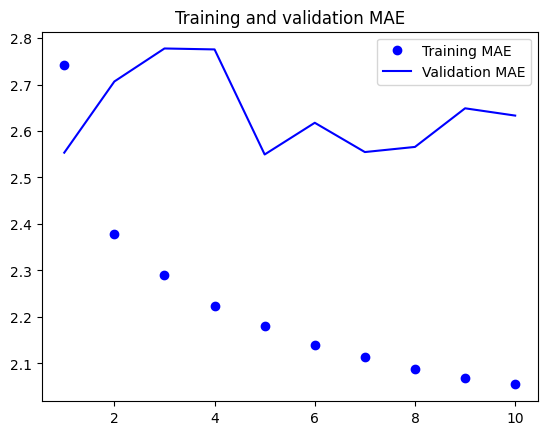

In [13]:
import matplotlib.pyplot as plt

loss     = history.history['mae']
val_loss = history.history['val_mae']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss    , 'bo', label='Training MAE')
plt.plot(epochs, val_loss, 'b' , label='Validation MAE')
plt.title('Training and validation MAE')

plt.legend()
plt.show()


### 10.2.4 一维卷积模型

In [14]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)

outputs = layers.Dense(1)(x)
model   = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 30s 35ms/step - loss: 24.7367 - mae: 3.8780 - val_loss: 18.5799 - val_mae: 3.3925
Epoch 2/10
819/819 [==============================] - 28s 34ms/step - loss: 19.1644 - mae: 3.4152 - val_loss: 18.2625 - val_mae: 3.3425
Epoch 3/10
819/819 [==============================] - 30s 37ms/step - loss: 17.5205 - mae: 3.2593 - val_loss: 16.2221 - val_mae: 3.1759
Epoch 4/10
819/819 [==============================] - 38s 46ms/step - loss: 16.4115 - mae: 3.1527 - val_loss: 17.1036 - val_mae: 3.2467
Epoch 5/10
819/819 [==============================] - 35s 42ms/step - loss: 15.5415 - mae: 3.0691 - val_loss: 17.1226 - val_mae: 3.2433
Epoch 6/10
819/819 [==============================] - 29s 36ms/step - loss: 14.8865 - mae: 3.0042 - val_loss: 17.3580 - val_mae: 3.2646
Epoch 7/10
819/819 [==============================] - 37s 45ms/step - loss: 14.3169 - mae: 2.9457 - val_loss: 17.4752 - val_mae: 3.2782
Epoch 8/10
819/819 [============================

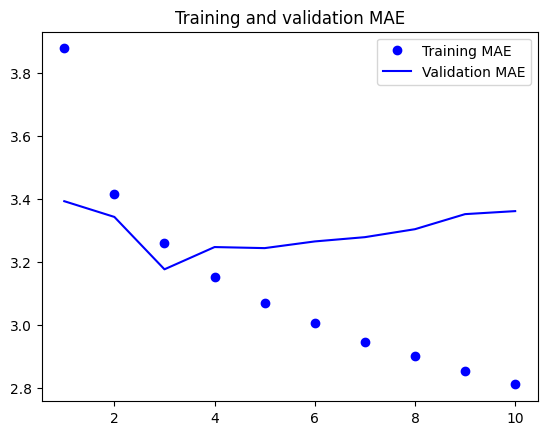

In [15]:
import matplotlib.pyplot as plt

loss     = history.history['mae']
val_loss = history.history['val_mae']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss    , 'bo', label='Training MAE')
plt.plot(epochs, val_loss, 'b' , label='Validation MAE')
plt.title('Training and validation MAE')

plt.legend()
plt.show()

### 10.2.5 第一个RNN基准

#### [C] 10.12 基于`LSTM(Long Short Term Memory)`的简单模型

In [16]:
inputs  = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x       = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model   = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 63s 74ms/step - loss: 44.7522 - mae: 4.9000 - val_loss: 13.6384 - val_mae: 2.8028
Epoch 2/10
819/819 [==============================] - 62s 75ms/step - loss: 11.3834 - mae: 2.6202 - val_loss: 9.8346 - val_mae: 2.4462
Epoch 3/10
819/819 [==============================] - 73s 89ms/step - loss: 9.9500 - mae: 2.4532 - val_loss: 10.2911 - val_mae: 2.4893
Epoch 4/10
819/819 [==============================] - 62s 76ms/step - loss: 9.4234 - mae: 2.3867 - val_loss: 9.9795 - val_mae: 2.4461
Epoch 5/10
819/819 [==============================] - 48s 58ms/step - loss: 8.9793 - mae: 2.3328 - val_loss: 10.0355 - val_mae: 2.4652
Epoch 6/10
819/819 [==============================] - 54s 66ms/step - loss: 8.5837 - mae: 2.2871 - val_loss: 9.7920 - val_mae: 2.4504
Epoch 7/10
819/819 [==============================] - 59s 72ms/step - loss: 8.2945 - mae: 2.2529 - val_loss: 10.3524 - val_mae: 2.5144
Epoch 8/10
819/819 [==============================] - 48

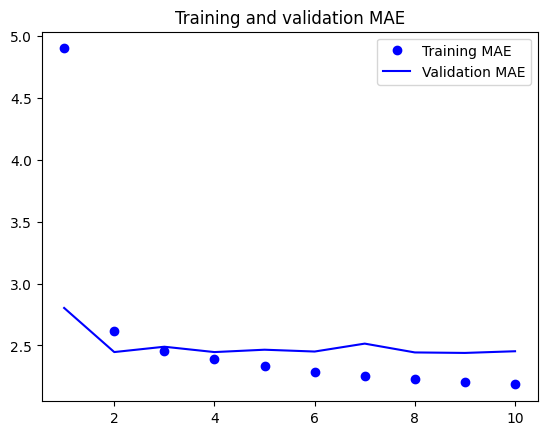

In [17]:
loss     = history.history['mae']
val_loss = history.history['val_mae']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss    , 'bo', label='Training MAE')
plt.plot(epochs, val_loss, 'b' , label='Validation MAE')
plt.title('Training and validation MAE')

plt.legend()
plt.show()

## 10.3 理解`RNN(recurrent neural networks)`

### [C] 10.13 RNN 伪代码(`Pseudocode`)

In [ ]:
state_t = 0
# 对序列元素进行遍历
for input_t in input_sequence:
    output_t = f(input_t, state_t)
    state_t  = output_t  # 上一次的输出变为下一次迭代的状态

### [C] 10.14 更详细的RNN代码

In [ ]:
state_t = 0
# 对序列元素进行遍历
for input_t in input_sequence:
    output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
    state_t  = output_t  # 上一次的输出变为下一次迭代的状态

### [C] 10.15 简单RNN的NumPy实现

In [18]:
import numpy as np

timesteps       = 100  # 输入序列的时间步数
input_features  = 32   # 输入特征空间的维度
output_features = 64   # 输出特征空间的维度

inputs  = np.random.random((timesteps, input_features))  # 输入数据:随机噪声,仅作为示例
state_t = np.zeros((output_features, ))                  # 初始状态:全零向量

# 创建随机的权重矩阵
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features, ))

successive_outputs = []

# 对输入和当前状态(上一个输出)进行计算,得到当前输出。这里使用tanh来添加非线性
for input_t in inputs:
    # input_t 是形状为(input_feature,)的向量
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    # 将输出保存到一个列表中
    successive_outputs.append(output_t)
    # 更新网络状态，用于下一个时间步
    state_t  = output_t

# 最终输出是形状为(timesteps, output_features)的2阶张量
final_output_sequence = np.stack(successive_outputs, axis=0)

### [C] 10.16 能够处理任意长度序列的RNN层

In [19]:
from tensorflow import keras
from tensorflow.keras import layers

num_features = 14
inputs  = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

### [C] 10.17 只返回最后一个时间步输出的RNN层

In [20]:
num_features = 14
steps        = 120
inputs       = keras.Input(shape=(steps, num_features))
outputs      = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


### [C] 10.18 返回完整输出序列的RNN层

In [4]:
num_features = 14
steps        = 120
inputs       = keras.Input(shape=(steps, num_features))
outputs      = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


### [C] 10.19 RNN层堆叠

In [21]:
inputs  = keras.Input(shape=(steps, num_features))
x       = layers.SimpleRNN(16, return_sequences=True)(inputs)
x       = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

### [C] 10.20 LSTM架构的详细伪代码

In [ ]:
output_t = activation(dot(state_t, Uo) + dot(input_t, Wo) + dot(c_t, Vo) + bo)
i_t      = activation(dot(state_t, Ui) + dot(input_t, Wi) + bi)
f_t      = activation(dot(state_t, Uf) + dot(input_t, Wf) + bf)
k_t      = activation(dot(state_t, Uk) + dot(input_t, Wk) + bk)

### [C] 10.21 LSTM架构的详细伪代码

In [ ]:
c_t + 1 = i_t * k_t + c_t * f_t

## 10.4 RNN的高级用法
---
* 循环 `dropout`(`recurrent dropout`)
* 循环层堆叠 `stacking recurrent layers`:提高模型的表示能力，代价是更大的计算量。
* 双向循环层 `bidirectional recurrent layer`:它会将相同的信息以不同的方式呈现给RNN，可以提高精度并缓解遗忘问题。

### 10.4.1 利用循环 `dropout` 降低过拟合

#### [C] 10.22 训练并评估一个使用 `dropout` 正则化的`LSTM`模型

In [22]:
inputs  = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x       = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x       = layers.Dropout(0.5)(x)  # 在LSTM层之后添加一个Dropout层，对Dense层进行正则化
outputs = layers.Dense(1)(x)

model   = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 124s 149ms/step - loss: 25.7421 - mae: 3.7653 - val_loss: 9.9743 - val_mae: 2.4544
Epoch 2/10
819/819 [==============================] - 147s 180ms/step - loss: 14.6731 - mae: 2.9769 - val_loss: 9.2399 - val_mae: 2.3642
Epoch 3/10
819/819 [==============================] - 145s 177ms/step - loss: 13.9255 - mae: 2.8917 - val_loss: 9.4298 - val_mae: 2.3851
Epoch 4/10
819/819 [==============================] - 142s 174ms/step - loss: 13.4329 - mae: 2.8391 - val_loss: 9.4781 - val_mae: 2.3848
Epoch 5/10
819/819 [==============================] - 148s 181ms/step - loss: 12.9857 - mae: 2.7905 - val_loss: 9.9536 - val_mae: 2.4146
Epoch 6/10
819/819 [==============================] - 156s 191ms/step - loss: 12.5862 - mae: 2.7511 - val_loss: 9.2094 - val_mae: 2.3554
Epoch 7/10
819/819 [==============================] - 145s 177ms/step - loss: 12.2402 - mae: 2.7141 - val_loss: 9.1019 - val_mae: 2.3379
Epoch 8/10
819/819 [=====================

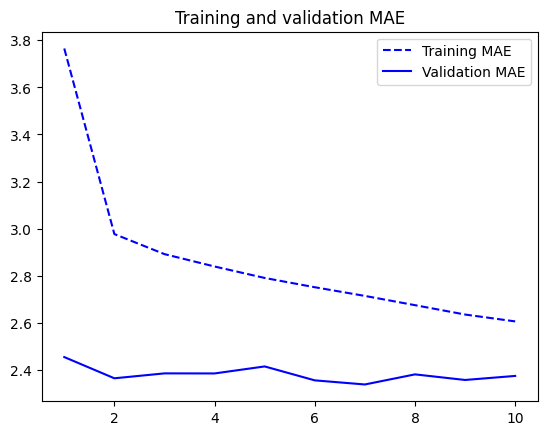

In [23]:
loss     = history.history['mae']
val_loss = history.history['val_mae']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss    , 'b--', label='Training MAE')
plt.plot(epochs, val_loss, 'b'  , label='Validation MAE')
plt.title('Training and validation MAE')

plt.legend()
plt.show()

In [24]:
inputs = keras.Input(shape=(sequence_length, num_features))
x      = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)  # 传入 unroll=True 将该层展开

### 10.4.2 循环层堆叠

#### [C] 10.23 训练并评估一个使用 `dropout` 正则化的堆叠 `GRU` 模型

In [25]:
inputs  = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x       = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x       = layers.GRU(32, recurrent_dropout=0.5)(x)
x       = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_stacked_gru_dropout.keras")

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 253s 304ms/step - loss: 26.8846 - mae: 3.8145 - val_loss: 9.6987 - val_mae: 2.4117
Epoch 2/10
819/819 [==============================] - 300s 366ms/step - loss: 14.1175 - mae: 2.9126 - val_loss: 9.2209 - val_mae: 2.3526
Epoch 3/10
819/819 [==============================] - 311s 380ms/step - loss: 13.2100 - mae: 2.8147 - val_loss: 8.8611 - val_mae: 2.3060
Epoch 4/10
819/819 [==============================] - 312s 381ms/step - loss: 12.5449 - mae: 2.7490 - val_loss: 8.9904 - val_mae: 2.3269
Epoch 5/10
819/819 [==============================] - 305s 372ms/step - loss: 12.0408 - mae: 2.6932 - val_loss: 9.2019 - val_mae: 2.3605
Epoch 6/10
819/819 [==============================] - 316s 386ms/step - loss: 11.6492 - mae: 2.6495 - val_loss: 9.0782 - val_mae: 2.3389
Epoch 7/10
819/819 [==============================] - 270s 329ms/step - loss: 11.1819 - mae: 2.5976 - val_loss: 9.0380 - val_mae: 2.3410
Epoch 8/10
819/819 [=====================

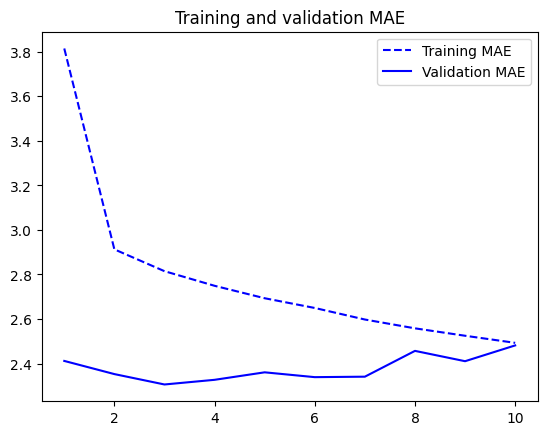

In [26]:
loss     = history.history['mae']
val_loss = history.history['val_mae']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss    , 'b--', label='Training MAE')
plt.plot(epochs, val_loss, 'b'  , label='Validation MAE')
plt.title('Training and validation MAE')

plt.legend()
plt.show()

### 10.4.3 使用双向RNN

#### [C] 10.24 训练并评估双向`LSTM`

In [ ]:
inputs  = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x       = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

In [ ]:
loss     = history.history['mae']
val_loss = history.history['val_mae']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss    , 'b--', label='Training MAE')
plt.plot(epochs, val_loss, 'b'  , label='Validation MAE')
plt.title('Training and validation MAE')

plt.legend()
plt.show()

### 10.4.4 进一步实验